In [197]:
reqPkgs = ['matplotlib', 'scipy', 'statsmodels', 'pandas', 'numpy', 'functools', 'ipython'
,'ipywidgets', 'seaborn']


In [198]:
import subprocess
import sys
reqs = subprocess.check_output([sys.executable, '-m', 'pip', 'freeze'])
installed_packages = [r.decode().split('==')[0] for r in reqs.split()]
print(installed_packages)

['argon2-cffi', 'argon2-cffi-bindings', 'asttokens', 'attrs', 'backcall', 'beautifulsoup4', 'bleach', 'cffi', 'click', 'click-didyoumean', 'colorama', 'cycler', 'debugpy', 'decorator', 'defusedxml', 'entrypoints', 'executing', 'fastjsonschema', 'fonttools', 'importlib-resources', 'ipykernel', 'ipython', 'ipython-genutils', 'ipywidgets', 'jedi', 'Jinja2', 'joblib', 'jsonschema', 'jupyter-client', 'jupyter-core', 'jupyterlab-pygments', 'jupyterlab-widgets', 'kaleido', 'kiwisolver', 'lxml', 'MarkupSafe', 'matplotlib', 'matplotlib-inline', 'mistune', 'nbclient', 'nbconvert', 'nbformat', 'nest-asyncio', 'notebook', 'numpy', 'p', 'packaging', 'pandas', 'pandocfilters', 'parso', 'patsy', 'pickleshare', 'Pillow', 'pkgutil_resolve_name', 'plotly', 'prometheus-client', 'prompt-toolkit', 'psutil', 'pure-eval', 'pyarrow', 'pycparser', 'Pygments', 'pyparsing', 'pyrsistent', 'python-dateutil', 'pytz', 'pywin32', 'pywinpty', 'PyYAML', 'pyzmq', 'scikit-learn', 'scipy', 'seaborn', 'Send2Trash', 'six', 

In [199]:
instPks = list(set(reqPkgs) - set(installed_packages))
print(instPks)


['functools']


In [200]:
""" %pip install matplotlib
%pip install statsmodels
%pip install ipywidgets
%pip install seaborn """

' %pip install matplotlib\n%pip install statsmodels\n%pip install ipywidgets\n%pip install seaborn '

In [201]:
""" for p in instPks:
    %pip install p """



' for p in instPks:\n    %pip install p '

In [2]:
import collections
from IPython.core.display import HTML
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
from functools import partial
import IPython
import ipywidgets
from ipywidgets import widgets
from ipywidgets import interact, interactive,fixed
import operator
from IPython.display import Javascript, display,HTML
from ipywidgets import widgets, VBox
import seaborn as sns
from collections import OrderedDict
import warnings
import getpass
import sys
warnings.filterwarnings('ignore')

class ConfUtility():   
    @staticmethod
    def parse_yaml(input_file):
        import yaml
        yaml_dict = {}
        with open (input_file,'r') as fin:
            try:
                yaml_dict = yaml.load(fin)
            except Exception as ex:
                print (ex)
        return yaml_dict

    @staticmethod
    def dict_to_htmllist(dc, include_list=None):
        dc2 = {}
        output_formatting = {'Target':'Target variable is ','CategoricalColumns':'Categorical Columns are ',
                           'NumericalColumns':'Numerical Columns are '}
        for each in dc.keys():
            if not include_list or each in include_list:
                if isinstance(dc[each],  collections.Iterable) and not isinstance(dc[each], str):
                    dc2[each] = ', \n'.join(val for val in dc[each])
                else:
                    dc2[each] = dc[each]
        html_list = "<ul>{}</ul>"
        html_list_entry = "<li>{}</li>"
        output3 = ''

        for each in set(include_list)|set(dc2.keys()):
            output3 += html_list_entry.format(output_formatting[each]+dc2[each])
        html_list = html_list.format(output3)
        return HTML(html_list)
    
class InteractionAnalytics():
    @staticmethod
    def rank_associations(df, conf_dict, col1, col2, col3):        
        try:
            col2 = int(col2)
            col3 = int(col3)
        except:
            pass
        
        # Passed Variable is Numerical
        if (col1 in NumericalColumns):
            fig,(ax1,ax2) = plt.subplots(1, 2)
            if len(NumericalColumns)>1:
                
                # Interaction with numerical variables
                df2 = df[NumericalColumns]
                corrdf = df2.corr()
                corrdf = abs(corrdf) 
                corrdf2 = corrdf[corrdf.index==col1].reset_index()[[each for each in corrdf.columns \
                                                      if col1 not in each]].unstack().sort_values(kind="quicksort", 
                                                                                                  ascending=False).head(col2)
                corrdf2 = corrdf2.reset_index()
                corrdf2.columns = ['level0','level1','rsq']
                corrdf2.set_index('level0', inplace=True)
                corrdf2[['rsq']].plot(kind='bar', ax=ax1)
                ax1.legend().set_visible(False)
                ax1.set_xlabel('Absolute Correlation')
                ax1.set_title('Top {} Associated Numeric Variables'.format(str(col2)))
                # Interaction with categorical variables
                etasquared_dict = {}
            if len(CategoricalColumns) >= 1:
                for each in CategoricalColumns:
                    mod = ols('{} ~ C({})'.format(col1, each),data=df[[col1,each]],missing='drop').fit()
                    aov_table = sm.stats.anova_lm(mod, typ=1)
                    esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
                    etasquared_dict[each] = esq_sm

                topk_esq = pd.DataFrame.from_dict(etasquared_dict, orient='index').unstack().sort_values(\
                    kind = 'quicksort', ascending=False).head(col3).reset_index().set_index('level_1')
                topk_esq.columns = ['level_0', 'EtaSquared']
                topk_esq[['EtaSquared']].plot(kind='bar',ax=ax2)
                ax2.legend().set_visible(False)
                ax2.set_xlabel('Eta-squared values')
                ax2.set_title('Top {}  Associated Categoric Variables'.format(str(col2)))
        # Passed Variable is Categorical
        else:
            #Interaction with numerical variables
            fig,(ax1,ax2) = plt.subplots(1,2)
            if len(NumericalColumns) >= 1:
                etasquared_dict = {}
                for each in NumericalColumns:
                    mod = ols('{} ~ C({})'.format(each, col1), data = df[[col1,each]]).fit()
                    aov_table = sm.stats.anova_lm(mod, typ=1)
                    esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
                    etasquared_dict[each] = esq_sm

                topk_esq = pd.DataFrame.from_dict(etasquared_dict, orient='index').unstack().sort_values(\
                    kind = 'quicksort', ascending=False).head(col2).reset_index().set_index('level_1')
                topk_esq.columns = ['level_0','EtaSquared']
                topk_esq[['EtaSquared']].plot(kind='bar',ax=ax1)
                ax1.legend().set_visible(False)
                ax1.set_xlabel('Eta-squared values')
                ax1.set_title('Top {} Associated Numeric Variables'.format(str(col2)))

            # Interaction with categorical variables
            cramer_dict = {}
            if len(CategoricalColumns)>1:
                for each in CategoricalColumns:
                    if each !=col1:
                        tbl = pd.crosstab(df[col1], df[each])
                        chisq = stats.chi2_contingency(tbl, correction=False)[0]
                        try:
                            cramer = np.sqrt(chisq/sum(tbl))
                        except:
                            cramer = np.sqrt(chisq/tbl.as_matrix().sum())
                            pass
                        cramer_dict[each] = cramer

                topk_cramer = pd.DataFrame.from_dict(cramer_dict, orient='index').unstack().sort_values(\
                    kind = 'quicksort', ascending=False).head(col3).reset_index().set_index('level_1')
                topk_cramer.columns = ['level_0','CramersV']
                topk_cramer[['CramersV']].plot(kind='bar',ax=ax2)
                ax2.legend().set_visible(False)
                ax2.set_xlabel("Cramer's V")
                ax2.set_title('Top {} Associated Categoric Variables'.format(str(col2)))
        
    @staticmethod
    def NoLabels(x):
        return ''
    
    @staticmethod
    def categorical_relations(df, col1, col2):
        if col1 != col2:
            df2 = df[(df[col1].isin(df[col1].value_counts().head(10).index.tolist()))&(df[col2].isin(df[col2].value_counts().head(10).index.tolist())) ]
            df3 = pd.crosstab(df2[col1], df2[col2])
            df3 = df3+1e-8
        else:
            df3 = pd.DataFrame(df[col1].value_counts())[:10]
        fig,ax = plt.subplots()
        fig,rects = mosaic(df3.unstack(),ax=ax, statistic=False, labelizer=InteractionAnalytics.NoLabels, label_rotation=30)
        ax.set_ylabel(col1)
        ax.set_xlabel(col2)
        ax.set_title('{} vs {}'.format(col1, col2) )
    
    @staticmethod
    def numerical_relations(df, col1, col2):
        from statsmodels.nonparametric.smoothers_lowess import lowess
        x = df[col2]
        y = df[col1]
        f, ax = plt.subplots(1)

        # lowess
        ax.scatter(x, y, c='g', s=6)
        lowess_results = lowess(y, x)#[:,1]
        xs = lowess_results[:, 0]
        ys = lowess_results[:, 1]
        ax.plot(xs,ys,'red',linewidth=1)

        #ols
        fit = np.polyfit(x, y, 1)
        fit1d = np.poly1d(fit)
        ax.plot(x, fit1d(x), '--b')
        ax.set_xlabel(col2)
        ax.set_ylabel(col1)
        corr = round(scipy.stats.pearsonr(x, y)[0], 6)
        ax.set_title('{} vs {}, Correlation {}'.format(col1, col2, corr))
    
    @staticmethod
    def numerical_correlation(df, conf_dict, col1):
        from matplotlib.pyplot import quiver, colorbar, clim,  matshow
        df2 = df[NumericalColumns].corr(method=col1)
        col_names = list(df[NumericalColumns].columns)
        fig,ax = plt.subplots(1, 1)
        m = ax.matshow(df2, cmap=matplotlib.pyplot.cm.coolwarm)
        ax.grid(b=False)
        fig.colorbar(m)
        ax.set_xticklabels([' '] + col_names) 
        ax.set_yticklabels([' '] + col_names)

    @staticmethod
    def numerical_pca(df, conf_dict, col1, col2, col3):
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler
        num_numeric = len(NumericalColumns)
        num_pca = num_numeric
        xticklabels = ['']
        for i in range(1,num_pca+1):
            xticklabels+=['Comp'+str(i)]
            xticklabels+=['']
        df2 = df[NumericalColumns]
        X = StandardScaler().fit_transform(df2.values)
        pca = PCA(n_components=num_pca)
        pca.fit(X)
        fig, (ax1,ax2) = plt.subplots(1, 2)
        ax1.bar(np.arange(1,(num_numeric+1),1),pca.explained_variance_ratio_ )
        ax1.set_ylabel('% Variance Explained')
        ax1.set_xticklabels(xticklabels)
        x_pca_index = int(col2) - 1
        y_pca_index = int(col3) - 1
        Y_pca = pd.DataFrame(pca.fit_transform(X))
        Y_pca_labels = []
        for i in range(1,num_pca+1):
            Y_pca_labels.append('PC'+str(i))
        Y_pca.columns = Y_pca_labels       
        Y_pca[col1] = df[col1]
        colors_dict = {}
        colors_list = ['r', 'y', 'c', 'y', 'k']
        j = 0
        for i in np.unique(df[col1]):
            colors_dict[i] = colors_list[j]
            j += 1
            if j == len(colors_list):
                j = 0
        colordf = pd.DataFrame.from_dict(colors_dict, orient='index').reset_index()
        colordf.columns = [col1, 'color']
        merged_df = pd.merge(colordf,Y_pca)
        grouped_df = merged_df.groupby(col1)
        for name, group in grouped_df:
            ax2.scatter(
               group[Y_pca.columns[x_pca_index]], group[Y_pca.columns[y_pca_index]],label=name,  
               c=group['color'],                            
               marker='o',                                
               s=6)                                       
        ax2.set_xlabel(Y_pca.columns[x_pca_index])
        ax2.set_ylabel(Y_pca.columns[y_pca_index])
        ax2.legend(title=col1, fontsize=14)
                
    @staticmethod
    def nc_relation(df, conf_dict, col1, col2, col3=None):
        fig,ax = plt.subplots()
        f = df[[col1,col2]].boxplot(by=col2, ax=ax)
        mod = ols('{} ~ {}'.format(col1, col2), data=df[[col1, col2]]).fit()
        aov_table = sm.stats.anova_lm(mod, typ=1)
        p_val = round(aov_table['PR(>F)'][0], 6)
        status = 'Passed'
        color = 'blue'
        if p_val < 0.05:
            status = 'Rejected'
            color = 'red'
        fig.suptitle('ho {} (p_value = {})'.format( status, p_val), color=color, fontsize=10)
    
    @staticmethod
    def pca_3d(df, conf_dict, col1, col2,  col3=None):
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler
        from mpl_toolkits.mplot3d import Axes3D
        df2 = df[NumericalColumns]
        X = StandardScaler().fit_transform(df2.values)
        pca = PCA(n_components=4)
        pca.fit(X)
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.view_init(elev=10, azim=int(col2))              
        Y_pca = pd.DataFrame(pca.fit_transform(X))
        Y_pca.columns = ['PC1','PC2','PC3','PC4']
        Y_pca[col1] = df[col1]
        colors_dict = {}
        colors_list = ['r', 'y', 'c', 'y', 'k']
        j = 0
        for i in np.unique(df[col1]):
            colors_dict[i] = colors_list[j]
            j += 1
            if j == len(colors_list):
                j = 0
        colordf = pd.DataFrame.from_dict(colors_dict, orient='index').reset_index()
        colordf.columns = [col1,'color']
        merged_df = pd.merge(colordf,Y_pca)
        grouped_df = merged_df.groupby(col1)
        for name, group in grouped_df:
            ax.scatter(
               group['PC1'], group['PC2'], group['PC3'], label=name,  
               c = group['color'],                            
               marker = 'o',                                
               s=6)                                      
        ax.set_xlabel('PC1', labelpad=18)
        ax.set_ylabel('PC2', labelpad=18)
        ax.set_zlabel('PC3', labelpad=18)
        ax.legend(title=col1, fontsize=10)

    @staticmethod
    def pca_3d_new(df, conf_dict, col1, col2, col3, col4, col5):
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler
        from mpl_toolkits.mplot3d import Axes3D
        df2 = df[NumericalColumns]
        X = StandardScaler().fit_transform(df2.values)
        num_numeric = len(NumericalColumns)
        pca = PCA(n_components=num_numeric)
        pca.fit(X)
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.view_init(elev=10, azim=int(col5))                 
        Y_pca = pd.DataFrame(pca.fit_transform(X))
        Y_pca_names = []
        for i in range(1, num_numeric+1):
            Y_pca_names.append('PC'+str(i))
        Y_pca.columns = Y_pca_names
        Y_pca[col1] = df[col1]
        colors_dict = {}
        colors_list = ['r', 'y', 'c', 'y', 'k']
        j = 0
        for i in np.unique(df[col1]):
            colors_dict[i] = colors_list[j]
            j += 1
            if j == len(colors_list):
                j = 0
        colordf = pd.DataFrame.from_dict(colors_dict, orient='index').reset_index()
        colordf.columns = [col1,'color']
        merged_df = pd.merge(colordf,Y_pca)
        grouped_df = merged_df.groupby(col1)
        for name, group in grouped_df:
            ax.scatter(
               group[Y_pca_names[int(col2)-1]], group[Y_pca_names[int(col3)-1]], group[Y_pca_names[int(col4)-1]], label=name,  
               c = group['color'],                            
               marker = 'o',                                
               s=6)
        ax.set_xlabel(Y_pca_names[int(col2)-1], labelpad=18)
        ax.set_ylabel(Y_pca_names[int(col3)-1], labelpad=18)
        ax.set_zlabel(Y_pca_names[int(col4)-1], labelpad=18)
        ax.legend(title=col1, fontsize=10)
        
    @staticmethod
    def nnc_relation(df, conf_dict, col1, col2, col3):
        import itertools
        markers = ['x', 'o', '^']
        color = itertools.cycle(['r', 'y', 'c', 'y', 'k']) 
        groups = df[[col1, col2, col3]].groupby(col3)

        # Plot
        fig, ax = plt.subplots()
        ax.margins(0.05) 

        for (name, group), marker in zip(groups, itertools.cycle(markers)):
            ax.plot(group[col1], group[col2], marker='o', linestyle='', ms=4, label=name)
        ax.set_xlabel(col1)
        ax.set_ylabel(col2)
        ax.legend(numpoints=1, loc='best', title=col3)
        
class TargetAnalytics():
    ReportedVariables = []
    @staticmethod
    def custom_barplot(df, col1=''):
        f, (ax0,ax1) = plt.subplots(1, 2)
        df[col1].value_counts().plot(ax=ax0, kind='bar')
        ax0.set_title('Bar Plot of {}'.format(col1))
        df[col1].value_counts().plot(ax=ax1, kind='pie')
        ax1.set_title('Pie Chart of {}'.format(col1))

class NumericAnalytics():
    @staticmethod
    def shapiro_test(x):
        #p_val = round(stats.shapiro(x)[1],6)
        p_val = stats.shapiro(x)[1]
        status = 'passed'
        color = 'blue'
        if p_val < 0.05:
            status = 'failed'
            color = 'red'
        return status, color, p_val

    @staticmethod
    def custom_barplot(df, col1=''):
        if len(df[col1]) > 5000:
            sampleSize = 5000
        else:
            sampleSize = len(df[col1])
        fig, axes = plt.subplots(2,2 , figsize=(11.5, 11.5))
        axes = axes.reshape(-1)
        df[col1].plot(ax=axes[0], kind='hist')
        axes[0].set_title('Histogram of {}'.format(col1))
        df[col1].plot(ax=axes[1], kind='kde')
        axes[1].set_title('Density Plot of {}'.format(col1))
        ax3 = plt.subplot(223)
        stats.probplot(df[col1], plot=plt)
        axes[2].set_title('QQ Plot of {}'.format(col1))
        df[col1].plot(ax=axes[3], kind='box')
        axes[3].set_title('Box Plot of {}'.format(col1))
        status, color, p_val = NumericAnalytics.shapiro_test(df[col1].sample(sampleSize))
        fig.suptitle('Normality test for {} {} (p_value = {})'.format(col1, status, p_val, color=color, fontsize=12))
    
class CategoricAnalytics():
    @staticmethod
    def custom_barplot(df, col1=''):
        f, (ax0,ax1) = plt.subplots(1,2)
        df[col1].value_counts().nlargest(10).plot(ax=ax0, kind='bar')
        ax0.set_xlabel(col1)
        ax0.set_title('Bar chart of {}'.format(col1))
        df[col1].value_counts().nlargest(10).plot(ax=ax1, kind='pie')
        ax1.set_title('Pie chart of {}'.format(col1))
 
%matplotlib inline
font={'family':'normal','weight':'normal','size':8}
matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12.0, 5.0)
matplotlib.rc('xtick', labelsize=9) 
matplotlib.rc('ytick', labelsize=9)
matplotlib.rc('axes', labelsize=10)
matplotlib.rc('axes', titlesize=10)
sns.set_style('whitegrid')

## <a name="read and summarize"></a> Read and Summarize the Data

### Load data from file

In [3]:
# Function to load the Dublin bus gz files 
def load_Files(direc, files, comtype):
    columns = ['Timestamp', 'LineID', 'Direction', 'JourneyPatternID', 'TimeFrame', 'VehicleJourneyID', 'Operator', 'Congestion', 'LonWGS84', 'LatWGS84', 'Delay', 'BlockID', 'VehicleID', 'StopID', 'AtStop']
    for f in files:
        print(f)
        yield pd.read_csv(direc + f, compression=comtype, delimiter=',', header=0, names=columns, parse_dates=True, low_memory=True)

def crackit_open(busFile):
    import zipfile as zip
    # Zip creates its own folders - no need to check for folder existence
    with zip.ZipFile(busFile,  mode='r') as arc: 
        arc.extractall('./Data/Bus/Gz/')  
    files = os.listdir('./Data/Bus/Gz/')
    DBfiles = [f for f in files if f.endswith('.gz')]
    df = pd.concat(load_Files('./Data/Bus/Gz/', DBfiles, 'gzip'), copy = False)
    return df


# Check parquet file existence before downloading - iof starting from afresh this takes a long time
if os.path.exists('./Data/WeatherandBusDat1.parquet'):
    print("Parquest file exists, means the Bus data has been downloaded already ")
    df = pd.read_parquet('./Data/WeatherandBusData.parquet')
elif os.path.exists('./Zips/Bus/DublinBusdata.zip'):
    print("Zip file exists, we have already downloaded the Dublin Bus Zip data, crack it open")
    df = crackit_open('./Zips/Bus/DublinBusdata.zip')
else:
    os.makedirs('./Zips/Bus/', exist_ok = True)
    url = "https://opendata.dublincity.ie/TrafficOpenData/sir010113-310113.zip"
    busFile = rq.urlretrieve(url, './Zips/Bus/DublinBusdata.zip' )  
    df = crackit_open('./Zips/Bus/DublinBusdata.zip')



Zip file exists, we have already downloaded the Dublin Bus Zip data, crack it open
siri.20130101.csv.gz
siri.20130102.csv.gz
siri.20130103.csv.gz
siri.20130104.csv.gz
siri.20130105.csv.gz
siri.20130106.csv.gz
siri.20130107.csv.gz
siri.20130108.csv.gz
siri.20130109.csv.gz
siri.20130110.csv.gz
siri.20130111.csv.gz
siri.20130112.csv.gz
siri.20130113.csv.gz
siri.20130114.csv.gz
siri.20130115.csv.gz
siri.20130116.csv.gz
siri.20130117.csv.gz
siri.20130118.csv.gz
siri.20130119.csv.gz
siri.20130120.csv.gz
siri.20130121.csv.gz
siri.20130122.csv.gz
siri.20130123.csv.gz
siri.20130124.csv.gz
siri.20130125.csv.gz
siri.20130126.csv.gz
siri.20130127.csv.gz
siri.20130128.csv.gz
siri.20130129.csv.gz
siri.20130130.csv.gz
siri.20130131.csv.gz


In [4]:
df.head()

,Timestamp,LineID,Direction,JourneyPatternID,TimeFrame,VehicleJourneyID,Operator,Congestion,LonWGS84,LatWGS84,Delay,BlockID,VehicleID,StopID,AtStop
0,1356998405000000,27.0,0,NaN,2012-12-31,3883,RD,0,-6.233417,53.342232,0,27017,33521,395.0,0
1,1356998407000000,40.0,0,NaN,2012-12-31,2226,HN,0,-6.278250,53.416683,0,40206,33142,6071.0,0
2,1356998407000000,7.0,0,00071003,2012-12-31,6106,D1,0,-6.231633,53.317768,0,7019,43004,3222.0,1
3,1356998411000000,747.0,0,07471001,2012-12-31,3531,SL,0,-6.254617,53.355484,-454,747007,40039,1445.0,0
4,1356998411000000,56.0,0,056A1001,2012-12-31,1830,RD,0,-6.233183,53.342201,0,56001,33488,2379.0,0


In [6]:
display(df['StopID'].unique())
display(max(df['StopID']))
display(min(df['StopID']))

array([ 395., 6071., 3222., ..., 3265., 6087., 4321.])

7552.0

2.0

In [20]:
display(len(df['JourneyPatternID'].index))

display( df['JourneyPatternID'].count())


44455102

37805187

In [205]:
# Deal with the timestamp and make it human readable and i will use this to merge datasets later
df['datetime'] = pd.to_datetime(df['Timestamp'], unit='us')
df['Time'] = df['datetime'].dt.time
df['Day'] = df['datetime'].dt.day
df['Hour'] = df['datetime'].dt.hour
df['Minute'] = df['datetime'].dt.minute
df['Year'] = df['datetime'].dt.year
df['Month'] = df['datetime'].dt.month
df['DayofWeek'] = df['datetime'].dt.day_of_week
df = df[df['Year'] == 2013]
df = df[df['Month'] == 1]

In [206]:
Phoenix_wdf = pd.read_csv('./Data/MetEirrean/hly175.csv', delimiter=',', header=0,  parse_dates=True, low_memory=True, skiprows=14, na_values='NAN')

Phoenix_wdf['datetime'] = pd.to_datetime(Phoenix_wdf['date'])
Phoenix_wdf['Year'] = Phoenix_wdf['datetime'].dt.year
Phoenix_wdf['Month'] = Phoenix_wdf['datetime'].dt.month
Phoenix_wdf['Day'] = Phoenix_wdf['datetime'].dt.day
Phoenix_wdf['Time'] = Phoenix_wdf['datetime'].dt.time
Phoenix_wdf['Hour'] = Phoenix_wdf['datetime'].dt.hour
Phoenix_wdf['Minute'] = Phoenix_wdf['datetime'].dt.minute
Phoenix_wdf['DayofWeek'] = Phoenix_wdf['datetime'].dt.day_of_week
#Filter the weather data to January 2013
Phoenix_wdf = Phoenix_wdf[Phoenix_wdf['Year'] == 2013]
Phoenix_wdf = Phoenix_wdf[Phoenix_wdf['Month'] == 1]
Phoenix_wdf = Phoenix_wdf.astype({"rain": float})
Phoenix_wdf = Phoenix_wdf.astype({"temp": float})
Phoenix_wdf = Phoenix_wdf.astype({"wetb": float})
Phoenix_wdf = Phoenix_wdf.astype({"dewpt": float})
Phoenix_wdf = Phoenix_wdf.astype({"vappr": float})
Phoenix_wdf = Phoenix_wdf.astype({"rhum": float})
Phoenix_wdf = Phoenix_wdf.astype({"msl": float})


Phoenix_wdf.dtypes

date                 object
ind                   int64
rain                float64
ind.1                 int64
temp                float64
ind.2                 int64
wetb                float64
dewpt               float64
vappr               float64
rhum                float64
msl                 float64
datetime     datetime64[ns]
Year                  int64
Month                 int64
Day                   int64
Time                 object
Hour                  int64
Minute                int64
DayofWeek             int64
dtype: object

In [207]:
def dropcols_func(df,ColumnsToExclude):
# Data is loaded - now needs to be cleaned, there is an argument to be made to include this in the above cell 
# but I have added it here so that I can add more columns to be excluded as I go rather than load the raw data each time
    for c in ColumnsToExclude:
        if c in df.columns:  # type: ignore
            df = df.drop(c, axis=1)  # type: ignore
        else:
            print('Columns already dropped')
    return df

In [208]:
ColumnsToExclude = ('ind', 'ind.1', 'ind.2')
Phoenix_wdf = dropcols_func(Phoenix_wdf, ColumnsToExclude)
Phoenix_wdf.head()

,date,rain,temp,wetb,dewpt,vappr,rhum,msl,datetime,Year,Month,Day,Time,Hour,Minute,DayofWeek
82223,01-jan-2013 00:00,0.0,3.1,2.4,1.4,6.8,88.0,1000.2,2013-01-01 00:00:00,2013,1,1,00:00:00,0,0,1
82224,01-jan-2013 01:00,0.0,3.3,2.5,1.2,6.6,85.0,1000.8,2013-01-01 01:00:00,2013,1,1,01:00:00,1,0,1
82225,01-jan-2013 02:00,0.0,2.9,2.2,1.2,6.7,88.0,1001.2,2013-01-01 02:00:00,2013,1,1,02:00:00,2,0,1
82226,01-jan-2013 03:00,0.0,2.7,2.1,1.1,6.6,89.0,1001.8,2013-01-01 03:00:00,2013,1,1,03:00:00,3,0,1
82227,01-jan-2013 04:00,0.1,2.5,1.9,1.0,6.6,90.0,1002.5,2013-01-01 04:00:00,2013,1,1,04:00:00,4,0,1


In [209]:


df.head()

,date,rain,temp,wetb,dewpt,vappr,rhum,msl,datetime,Year,...,Congestion,LonWGS84,LatWGS84,Delay,BlockID,VehicleID,StopID,AtStop,Ontime,Colour
0,01-jan-2013 11:00,0.0,3.6,2.7,1.2,6.7,84.0,1009.0,2013-01-01 11:00:00,2013,...,0,-6.116812,53.499493,-20,332001,33625,3732.0,0,1,Purple
1,01-jan-2013 11:00,0.0,3.6,2.7,1.2,6.7,84.0,1009.0,2013-01-01 11:00:00,2013,...,0,-6.212467,53.324749,0,1001,33384,381.0,1,1,Purple
2,01-jan-2013 11:00,0.0,3.6,2.7,1.2,6.7,84.0,1009.0,2013-01-01 11:00:00,2013,...,0,-6.451066,53.347698,0,25003,33403,4620.0,1,1,Purple
3,01-jan-2013 11:00,0.0,3.6,2.7,1.2,6.7,84.0,1009.0,2013-01-01 11:00:00,2013,...,0,-6.394768,53.393051,-333,39002,33585,4489.0,0,0,Brown
4,01-jan-2013 11:00,0.0,3.6,2.7,1.2,6.7,84.0,1009.0,2013-01-01 11:00:00,2013,...,0,-6.373067,53.286098,0,76002,33409,4341.0,1,1,Purple


In [210]:
#join weather and bus 
df = pd.merge(Phoenix_wdf, df)

df = df.astype({"rain": float})
df = df.astype({"temp": float})
df = df.astype({"wetb": float})
df = df.astype({"dewpt": float})
df = df.astype({"vappr": float})
df = df.astype({"rhum": float})
df = df.astype({"msl": float})

df.head()



,date,rain,temp,wetb,dewpt,vappr,rhum,msl,datetime,Year,...,Congestion,LonWGS84,LatWGS84,Delay,BlockID,VehicleID,StopID,AtStop,Ontime,Colour
0,01-jan-2013 11:00,0.0,3.6,2.7,1.2,6.7,84.0,1009.0,2013-01-01 11:00:00,2013,...,0,-6.116812,53.499493,-20,332001,33625,3732.0,0,1,Purple
1,01-jan-2013 11:00,0.0,3.6,2.7,1.2,6.7,84.0,1009.0,2013-01-01 11:00:00,2013,...,0,-6.212467,53.324749,0,1001,33384,381.0,1,1,Purple
2,01-jan-2013 11:00,0.0,3.6,2.7,1.2,6.7,84.0,1009.0,2013-01-01 11:00:00,2013,...,0,-6.451066,53.347698,0,25003,33403,4620.0,1,1,Purple
3,01-jan-2013 11:00,0.0,3.6,2.7,1.2,6.7,84.0,1009.0,2013-01-01 11:00:00,2013,...,0,-6.394768,53.393051,-333,39002,33585,4489.0,0,0,Brown
4,01-jan-2013 11:00,0.0,3.6,2.7,1.2,6.7,84.0,1009.0,2013-01-01 11:00:00,2013,...,0,-6.373067,53.286098,0,76002,33409,4341.0,1,1,Purple


Check Columns and column types -- correct/modify as necessary 

In [211]:
df.dtypes

date                        object
rain                       float64
temp                       float64
wetb                       float64
dewpt                      float64
vappr                      float64
rhum                       float64
msl                        float64
datetime            datetime64[ns]
Year                         int64
Month                        int64
Day                          int64
Time                        object
Hour                         int64
Minute                       int64
DayofWeek                    int64
Timestamp                    int64
LineID                     float64
Direction                    int64
JourneyPatternID            object
TimeFrame                   object
VehicleJourneyID             int64
Operator                    object
Congestion                   int64
LonWGS84                   float64
LatWGS84                   float64
Delay                        int64
BlockID                      int64
VehicleID           

In [212]:
df['Ontime'] = df['Delay'].apply(lambda x: 0 if (x < -300) or (x > 300) else 1)

In [213]:

#remove the space in column names
df.columns = [x.strip().replace(' ', '') for x in df.columns]

df.head()

,date,rain,temp,wetb,dewpt,vappr,rhum,msl,datetime,Year,...,Congestion,LonWGS84,LatWGS84,Delay,BlockID,VehicleID,StopID,AtStop,Ontime,Colour
0,01-jan-2013 11:00,0.0,3.6,2.7,1.2,6.7,84.0,1009.0,2013-01-01 11:00:00,2013,...,0,-6.116812,53.499493,-20,332001,33625,3732.0,0,1,Purple
1,01-jan-2013 11:00,0.0,3.6,2.7,1.2,6.7,84.0,1009.0,2013-01-01 11:00:00,2013,...,0,-6.212467,53.324749,0,1001,33384,381.0,1,1,Purple
2,01-jan-2013 11:00,0.0,3.6,2.7,1.2,6.7,84.0,1009.0,2013-01-01 11:00:00,2013,...,0,-6.451066,53.347698,0,25003,33403,4620.0,1,1,Purple
3,01-jan-2013 11:00,0.0,3.6,2.7,1.2,6.7,84.0,1009.0,2013-01-01 11:00:00,2013,...,0,-6.394768,53.393051,-333,39002,33585,4489.0,0,0,Brown
4,01-jan-2013 11:00,0.0,3.6,2.7,1.2,6.7,84.0,1009.0,2013-01-01 11:00:00,2013,...,0,-6.373067,53.286098,0,76002,33409,4341.0,1,1,Purple


In [214]:
# Getting the list of categorical columns if it was not there in the yaml file
CategoricalColumns = list(set(list(df.select_dtypes(exclude=[np.number]).columns)))

NumericalColumns = list(set(list(df.select_dtypes([np.number]).columns)))

In [215]:
print(CategoricalColumns)

['TimeFrame', 'Time', 'Colour', 'date', 'datetime', 'Operator', 'JourneyPatternID']


In [216]:
print(NumericalColumns)

['Ontime', 'Minute', 'Hour', 'Month', 'Day', 'dewpt', 'VehicleID', 'BlockID', 'Timestamp', 'Year', 'LineID', 'LonWGS84', 'temp', 'vappr', 'Direction', 'msl', 'Delay', 'AtStop', 'wetb', 'LatWGS84', 'DayofWeek', 'VehicleJourneyID', 'rain', 'rhum', 'StopID', 'Congestion']


# Exclude columns that we do not need

In [217]:
ColumnsToExclude = ['Direction', 'JourneyPatternID', 'StopID']
CategoricalColumns = list(set(CategoricalColumns) - set(ColumnsToExclude))
NumericalColumns = list(set(NumericalColumns)-set(ColumnsToExclude))


In [218]:
#df = df.drop(ColumnsToExclude, axis=1)
df = df.dropna()

### Print the dimensions of the data (rows, columns)

In [219]:
print ('The data has {} Rows and {} columns'.format(df.shape[0],df.shape[1]))

The data has 3831 Rows and 33 columns


### Print the dimensions of the data (rows, columns)

In [220]:
col_names = ','.join(each for each in list(df.columns))
print("The column names are:" + col_names)

The column names are:date,rain,temp,wetb,dewpt,vappr,rhum,msl,datetime,Year,Month,Day,Time,Hour,Minute,DayofWeek,Timestamp,LineID,Direction,JourneyPatternID,TimeFrame,VehicleJourneyID,Operator,Congestion,LonWGS84,LatWGS84,Delay,BlockID,VehicleID,StopID,AtStop,Ontime,Colour


### Print the column types

In [221]:
print("The types of columns are:")
df.dtypes

The types of columns are:


date                        object
rain                       float64
temp                       float64
wetb                       float64
dewpt                      float64
vappr                      float64
rhum                       float64
msl                        float64
datetime            datetime64[ns]
Year                         int64
Month                        int64
Day                          int64
Time                        object
Hour                         int64
Minute                       int64
DayofWeek                    int64
Timestamp                    int64
LineID                     float64
Direction                    int64
JourneyPatternID            object
TimeFrame                   object
VehicleJourneyID             int64
Operator                    object
Congestion                   int64
LonWGS84                   float64
LatWGS84                   float64
Delay                        int64
BlockID                      int64
VehicleID           

## <a name="descriptive statistics"></a>Extract Descriptive Statistics of Each Column

In [222]:
def num_missing(x):
    return len(x.index)-x.count()

def num_unique(x):
    return len(np.unique(x))

In [223]:
types_df = pd.DataFrame(df.dtypes)

In [224]:
temp_df = df.describe().T
missing_df = pd.DataFrame(df.apply(num_missing, axis=0)) 
missing_df.columns = ['missing']
unq_df = pd.DataFrame(df.apply(num_unique, axis=0))
unq_df.columns = ['unique']
types_df = pd.DataFrame(df.dtypes)
types_df.columns = ['DataType']


### Print the descriptive statistics of numerical columns

In [225]:

summary_df = temp_df.join(missing_df).join(unq_df).join(types_df)
summary_df


,count,mean,std,min,25%,50%,75%,max,missing,unique,DataType
rain,3831.0,1.571391e-01,4.947722e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.400000e+00,0,17,float64
temp,3831.0,6.754085e+00,3.805540e+00,-1.700000e+00,4.000000e+00,7.200000e+00,1.050000e+01,1.390000e+01,0,95,float64
wetb,3831.0,5.709110e+00,3.678459e+00,-1.700000e+00,2.600000e+00,5.800000e+00,9.500000e+00,1.240000e+01,0,92,float64
dewpt,3831.0,4.310154e+00,3.874800e+00,-3.000000e+00,6.000000e-01,4.600000e+00,8.300000e+00,1.090000e+01,0,90,float64
vappr,3831.0,8.591334e+00,2.300097e+00,4.900000e+00,6.400000e+00,8.500000e+00,1.100000e+01,1.310000e+01,0,66,float64
rhum,3831.0,8.422448e+01,6.784311e+00,6.000000e+01,7.900000e+01,8.600000e+01,8.900000e+01,1.000000e+02,0,35,float64
msl,3831.0,1.013223e+03,1.274683e+01,9.854000e+02,1.004100e+03,1.014200e+03,1.022200e+03,1.034800e+03,0,135,float64
Year,3831.0,2.013000e+03,0.000000e+00,2.013000e+03,2.013000e+03,2.013000e+03,2.013000e+03,2.013000e+03,0,1,int64
Month,3831.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0,1,int64
Day,3831.0,1.380867e+01,8.821034e+00,1.000000e+00,7.000000e+00,1.400000e+01,2.200000e+01,3.100000e+01,0,31,int64


### Print the descriptive statistics of categorical columns

In [226]:
col_names = list(types_df.index)
num_cols = len(col_names)
index = range(num_cols)
cat_index = []
for i in index:
    if col_names[i] in CategoricalColumns:
        cat_index.append(i)
summary_df_cat = missing_df.join(unq_df).join(types_df.iloc[cat_index], how='inner') #Only summarize categorical columns
summary_df_cat

,missing,unique,DataType
date,0,165,object
datetime,0,165,datetime64[ns]
Time,0,18,object
TimeFrame,0,31,object
Operator,0,8,object
Colour,0,2,object


## <a name="individual variables"></a>Explore Individual Variables

In [227]:
NumericalColumns

['temp',
 'vappr',
 'Ontime',
 'Minute',
 'Hour',
 'msl',
 'Delay',
 'AtStop',
 'Month',
 'wetb',
 'Day',
 'dewpt',
 'VehicleID',
 'LatWGS84',
 'DayofWeek',
 'BlockID',
 'VehicleJourneyID',
 'rain',
 'rhum',
 'Timestamp',
 'Year',
 'LineID',
 'LonWGS84',
 'Congestion']

In [228]:
CategoricalColumns = ['Ontime','Congestion','VehicleID','LineID','BlockID','Operator']
NumericalColumns = ['Delay','rain', 'temp', 'DayofWeek','LonWGS84','LatWGS84','Hour','Day']
Target = 'Ontime' #'Delay','Congestion'

### Explore the target variable

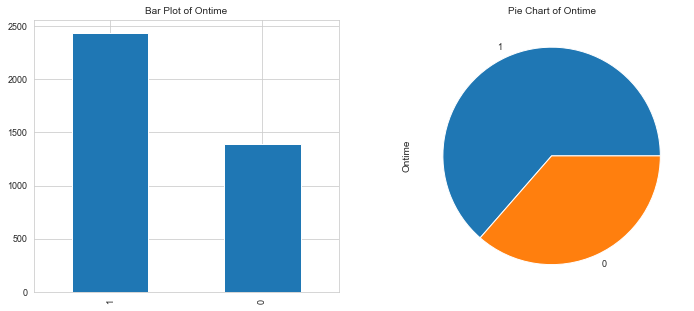

In [229]:
if Target in CategoricalColumns:
    w1_value = ''
    w1 = None  
    w1 = widgets.Dropdown(
        options=[Target],
        value=Target,
        description='Target Variable:',
    )
    i = interactive(TargetAnalytics.custom_barplot, df=fixed(df), col1=w1)
    hbox = widgets.HBox(i.children[:1])
    display(hbox)
    hbox.on_displayed(TargetAnalytics.custom_barplot(df=df, col1=w1.value))
else:
    w1_value = ''
    w1 = None
    w1 = widgets.Dropdown(
            options=[Target],
            value=Target,
            description='Target Variable:',
        )
    i = interactive(NumericAnalytics.custom_barplot, df=fixed(df), col1=w1)
    hbox = widgets.HBox(i.children)
    display(hbox)
    hbox.on_displayed(NumericAnalytics.custom_barplot(df=df, col1=w1.value))

### Explore individual numeric variables and test for normality 

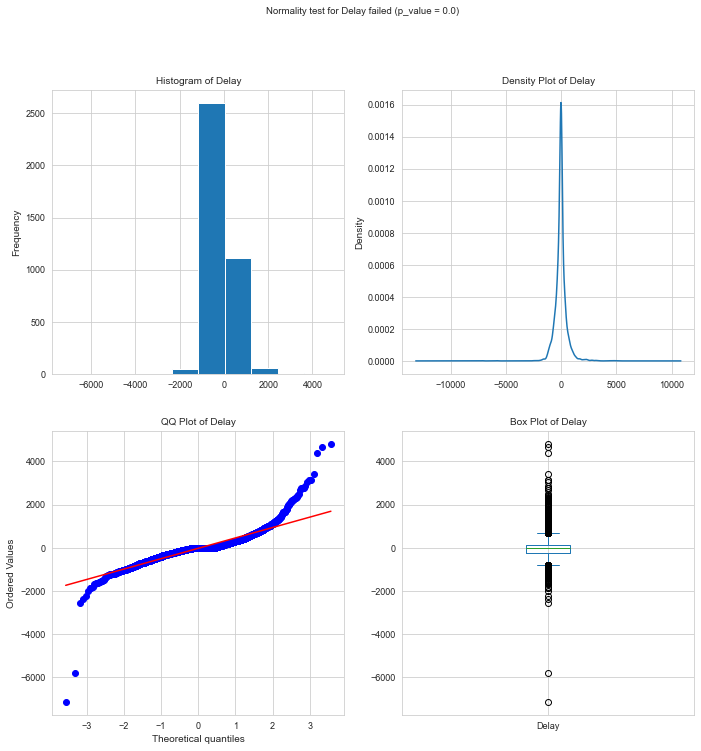

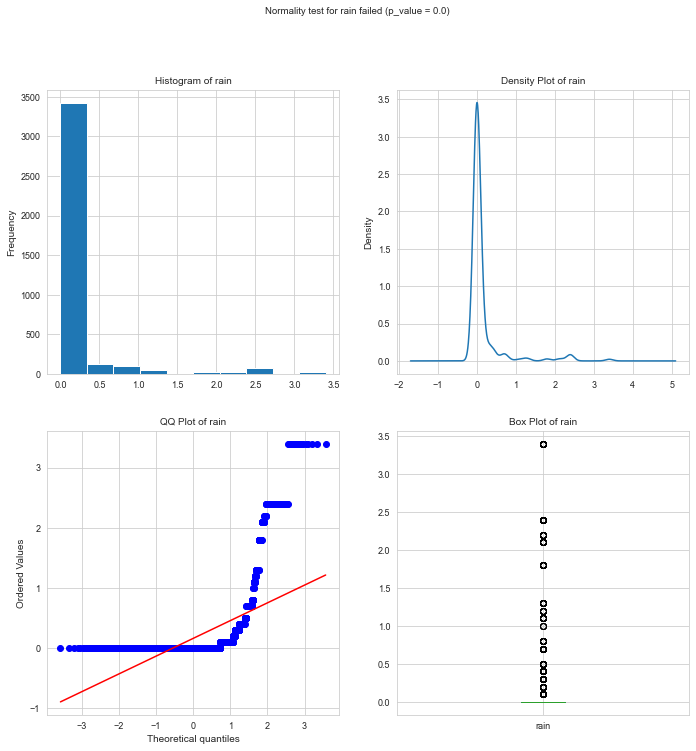

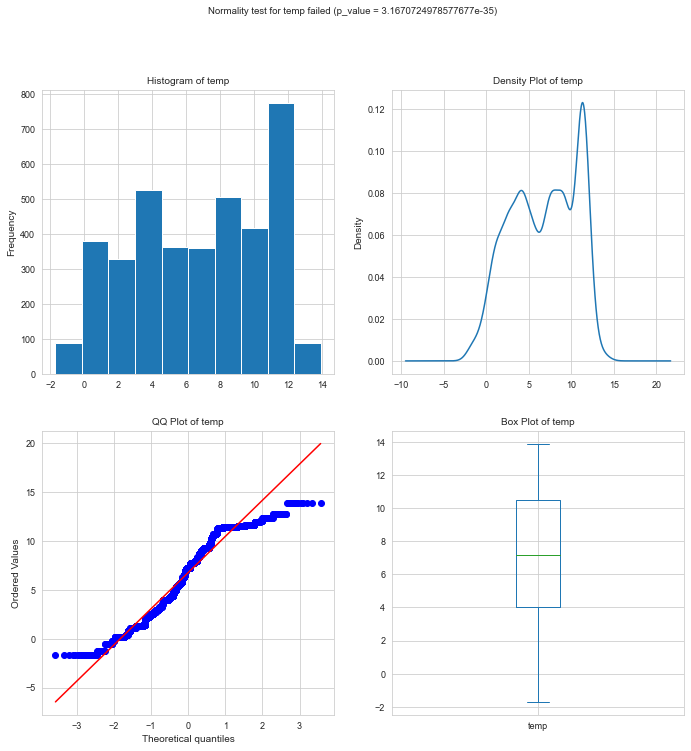

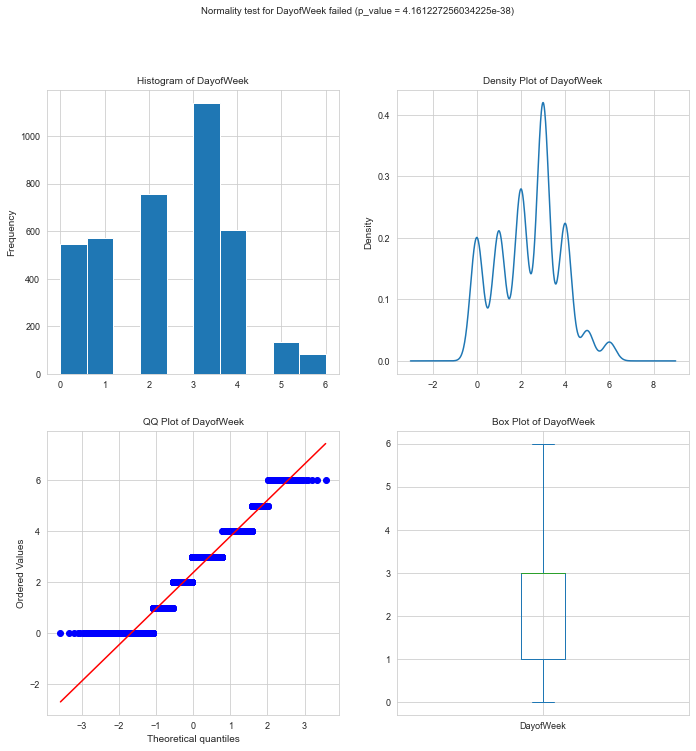

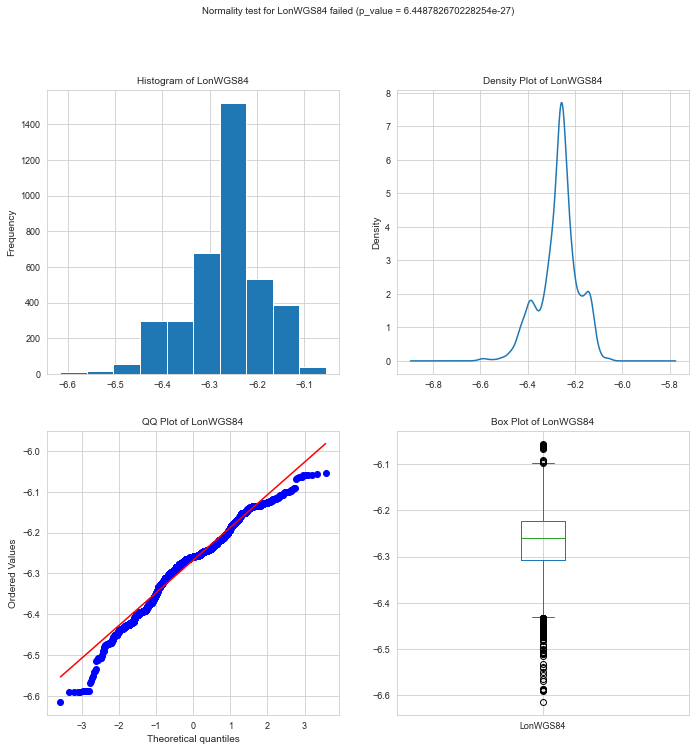

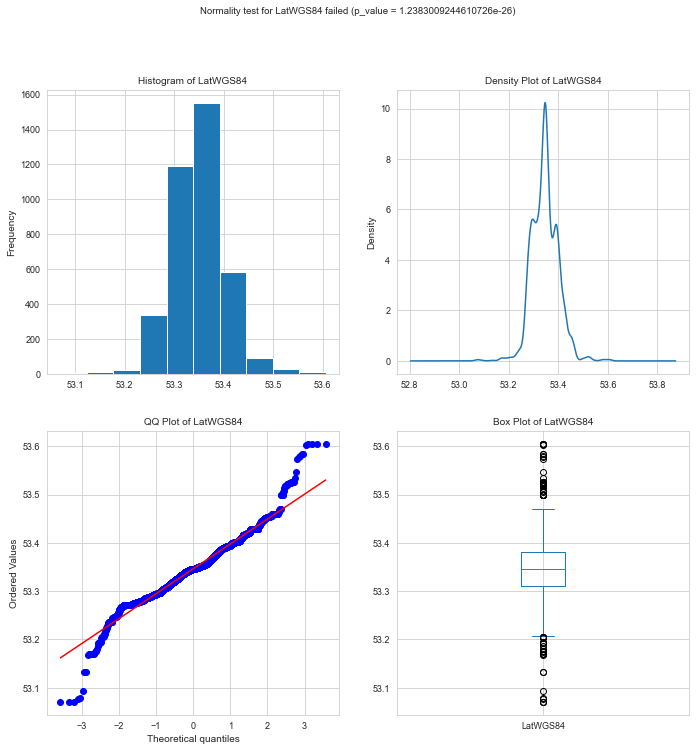

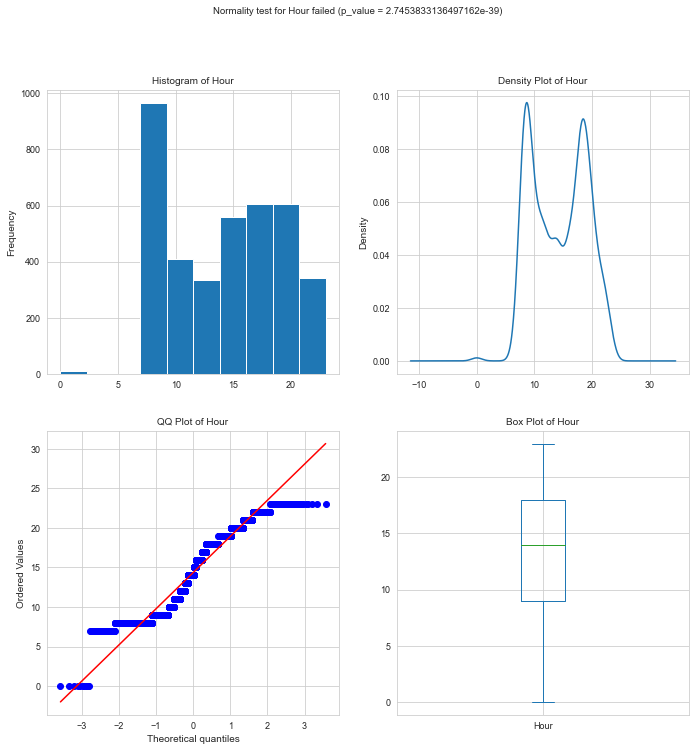

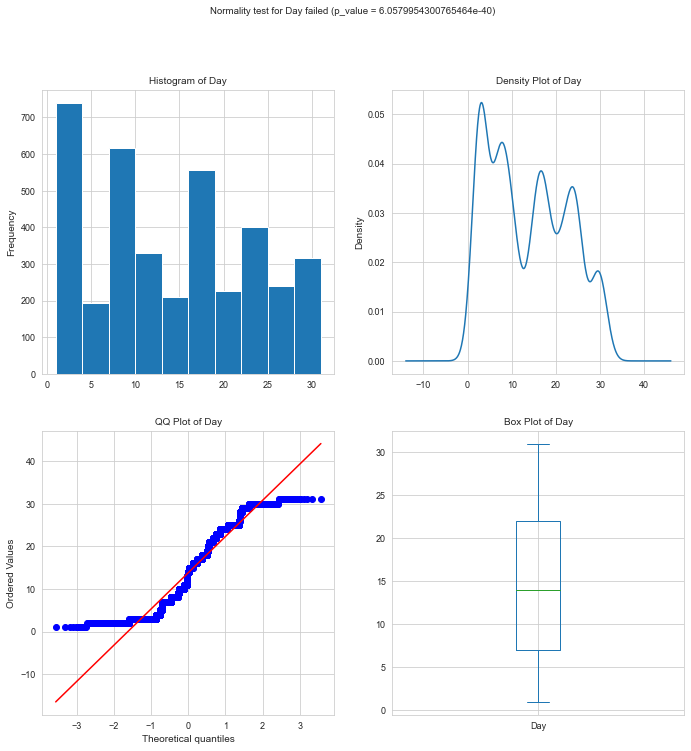

In [230]:
for f in NumericalColumns:
    NumericAnalytics.custom_barplot( df=df, col1=f)


In [ ]:
w1_value = ''
w1 = None
w1 = widgets.Dropdown(
        options=NumericalColumns,
        value=NumericalColumns[0],
        description='Numeric Variable:',
    )

i = interactive(NumericAnalytics.custom_barplot, df=fixed(df), col1=w1)
hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(NumericAnalytics.custom_barplot(df=df, col1=w1.value))

### Explore individual categorical variables (sorted by frequencies)

In [ ]:
w1_value = ''
w1 = None

w1 = widgets.Dropdown(
    options = CategoricalColumns,
    value = CategoricalColumns[0],
    description = 'Categorical Variable:',
)


i = interactive(CategoricAnalytics.custom_barplot, df=fixed(df), col1=w1)
hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(CategoricAnalytics.custom_barplot(df=df, col1=w1.value))

## <a name="multiple variables"></a>Explore Interactions Between Variables
### <a name="rank variables"></a>Rank variables based on linear relationships with reference variable

In [ ]:
cols_list = [Target] + NumericalColumns + CategoricalColumns
cols_list = list(OrderedDict.fromkeys(cols_list)) 
w1 = widgets.Dropdown(    
    options=cols_list,
    value=cols_list[0],
    description='Ref Var:'
)
w2 = ipywidgets.Text(value="5", description='Top Num Vars:')
w3 = ipywidgets.Text(value="5", description='Top Cat Vars:')
i = interactive(InteractionAnalytics.rank_associations, df=fixed(df),conf_dict=fixed(cols_list), col1=w1, col2=w2, col3=w3)
hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(InteractionAnalytics.rank_associations(df=df, conf_dict=cols_list, col1=w1.value, col2=w2.value, col3=w3.value))

### <a name="two categorical"></a>Explore interactions between categorical variables

In [ ]:
# import useful library
import numpy as np
from numpy.random import poisson
from numpy.random import seed
from scipy.stats import shapiro
from numpy.random import randn

seed(30)
# Create data
gfg_data = poisson(5, 200)
d2 = randn(500)

# conduct the Shapiro-Wilk Test
display(shapiro(gfg_data))
display(shapiro(df['temp']))

display(shapiro(df["temp"].sample(5000, replace=True))[1])

NumericAnalytics.custom_barplot( df=df, col1='temp')

In [ ]:
w1, w2 = None, None

if Target in CategoricalColumns:
    cols_list = [Target] + CategoricalColumns 
    cols_list = list(OrderedDict.fromkeys(cols_list)) 
else:
    cols_list = CategoricalColumns
    
w1 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[0],
    description='Categorical Var 1:'
)
w2 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[1],
    description='Categorical Var 2:'
)

i = interactive(InteractionAnalytics.categorical_relations, df=fixed(df), col1=w1, col2=w2)
hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(InteractionAnalytics.categorical_relations(df=df, col1=w1.value, col2=w2.value))

### <a name="two numerical"></a>Explore interactions between numerical variables

In [ ]:
w1, w2 = None, None

if Target in NumericalColumns:
    cols_list = [Target] + NumericalColumns 
    cols_list = list(OrderedDict.fromkeys(cols_list)) 
else:
    cols_list = NumericalColumns
w1 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[0],
    description='Numerical Var 1:'
)
w2 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[1],
    description='Numerical Var 2:'
)

i = interactive(InteractionAnalytics.numerical_relations, df=fixed(df), col1=w1, col2=w2)
hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(InteractionAnalytics.numerical_relations(df, col1=w1.value, col2=w2.value))

### Explore correlation matrix between numerical variables

In [ ]:
w1 = None
w1 = widgets.Dropdown(
    options=['pearson','kendall','spearman'],
    value='pearson',
    description='Correlation Method:'
)
i = interactive(InteractionAnalytics.numerical_correlation, df=fixed(df), conf_dict=fixed(cols_list), col1=w1)
hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(InteractionAnalytics.numerical_correlation(df, conf_dict=cols_list, col1=w1.value))

### <a name="numerical and categorical"></a>Explore interactions between numerical and categorical variables

In [ ]:
w1, w2 = None, None

if Target in NumericalColumns:
    cols_list = [Target] + NumericalColumns #Make target the default reference variable
    cols_list = list(OrderedDict.fromkeys(cols_list)) #remove variables that might be duplicates with target
else:
    cols_list = NumericalColumns
    
w1 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[0],
    description='Numerical Variable:'
)

if Target in CategoricalColumns:
    cols_list = [Target] + CategoricalColumns #Make target the default reference variable
    cols_list = list(OrderedDict.fromkeys(cols_list)) #remove variables that might be duplicates with target
else:
    cols_list = CategoricalColumns
    
w2 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[0],
    description='Categorical Variable:'
)
i = interactive(InteractionAnalytics.nc_relation, df=fixed(df),conf_dict=fixed(cols_list), col1=w1, col2=w2, col3=fixed(w3))
hbox = widgets.HBox(i.children)
display( hbox )
hbox.on_displayed(InteractionAnalytics.nc_relation(df, cols_list, col1=w1.value, col2=w2.value))

### <a name="two numerical and categorical"></a>Explore interactions between two numerical variables and a categorical variable

In [ ]:
w1, w2, w3 = None, None, None

if Target in NumericalColumns:
    cols_list = [Target] + NumericalColumns 
    cols_list = list(OrderedDict.fromkeys(cols_list)) 
else:
    cols_list = NumericalColumns
    
w1 = widgets.Dropdown(
    options = cols_list,
    value = cols_list[0],
    description = 'Numerical Var 1:'
)
w2 = widgets.Dropdown(
    options = cols_list,
    value = cols_list[1],
    description = 'Numerical Var 2:'
)

if Target in CategoricalColumns:
    cols_list = [Target] + CategoricalColumns
    cols_list = list(OrderedDict.fromkeys(cols_list)) 
else:
    cols_list = CategoricalColumns
    
w3 = widgets.Dropdown(
    options = cols_list,
    value = cols_list[0],
    description = 'Legend Cat Var:'
)
i = interactive(InteractionAnalytics.nnc_relation, df=fixed(df),conf_dict=fixed(cols_list), col1=w1, col2=w2, col3=w3)
hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(InteractionAnalytics.nnc_relation(df, cols_list, col1=w1.value,col2=w2.value, col3=w3.value))

## <a name="pca"></a>Visualize numerical data by projecting to principal component spaces

### Project data to 2-D principal component space 

In [ ]:
num_numeric = len(NumericalColumns)
if  num_numeric > 3:
    
    w1, w2, w3 = None, None, None
    if Target in CategoricalColumns:
        cols_list = [Target] + CategoricalColumns 
        cols_list = list(OrderedDict.fromkeys(cols_list)) 
    else:
        cols_list = CategoricalColumns
    w1 = widgets.Dropdown(
        options = cols_list,
        value = cols_list[0],
        description = 'Legend Variable:',
        width = 10
    )
    w2 = widgets.Dropdown(
        options = [str(x) for x in np.arange(1,num_numeric+1)],
        value = '1',
        width = 1,
        description='PC at X-Axis:'
    )
    w3 = widgets.Dropdown(
        options = [str(x) for x in np.arange(1,num_numeric+1)],
        value = '2',
        description = 'PC at Y-Axis:'
    )
    i = interactive(InteractionAnalytics.numerical_pca, df=fixed(df),conf_dict=fixed(cols_list), col1=w1, col2=w2, col3=w3)
    hbox = widgets.HBox(i.children[:3])
    display(hbox)
    hbox.on_displayed(InteractionAnalytics.numerical_pca(df, conf_dict=cols_list, col1=w1.value, col2=w2.value, col3=w3.value))

### Project data to 3-D principal component space

In [ ]:
if len(NumericalColumns) > 3:
    if Target in CategoricalColumns:
        cols_list = [Target] + CategoricalColumns 
        cols_list = list(OrderedDict.fromkeys(cols_list)) 
    else:
        cols_list = CategoricalColumns
    w1, w2 = None, None
    w1 = widgets.Dropdown(
        options=cols_list,
        value=cols_list[0],
        description='Legend Variable:'
    )
    w2 = ipywidgets.IntSlider(min=-180, max=180, step=5, value=30, description='Angle')
    i = interactive(InteractionAnalytics.pca_3d, df=fixed(df), conf_dict=fixed(cols_list),col1=w1, col2=w2, col3=fixed(w3))
    hbox=widgets.HBox(i.children[:2])
    display(hbox)
    hbox.on_displayed(InteractionAnalytics.pca_3d(df,cols_list,col1=w1.value,col2=w2.value))

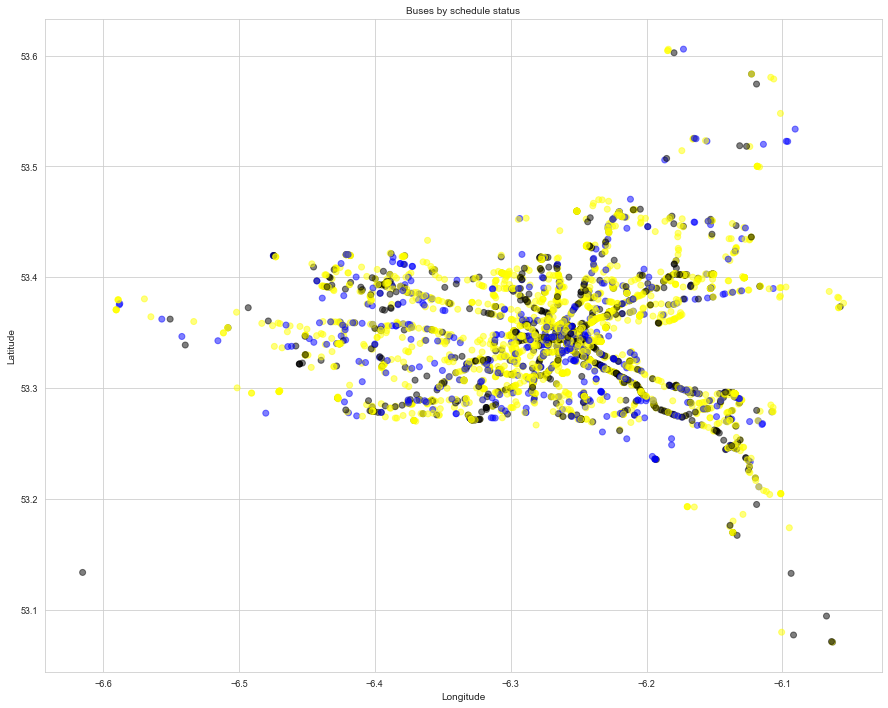

In [239]:
df['Colour'] = df['Delay'].apply(lambda x: 'Black' if (x < -300)  else 'Blue' if  (x > 300)  else 'Yellow')
fig, ax = plt.subplots(figsize=(15,12))
plt.scatter(x=df['LonWGS84'], y=df['LatWGS84'], alpha=0.5,  c=df['Colour'] )
plt.title('Buses by schedule status')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show();